In [2]:
import torch
import json
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [209]:
# LOAD FINE-TUNED MODEL FROM DISK

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load('./torch-cache/test3.ckpt', map_location=torch.device(device))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

with open('./torch-cache/authors.json') as file:
    authors = json.load(file)
    print(f"Authors list: {authors}")
    print(f"model running on {device}")

C:\Users\kauhe\AppData\Local\Temp\ipykernel_31024\4082540394.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./torch-cache/test3.ckpt', map_location=

Total number of parameters: 109489161
Authors list: ['dekker', 'fletcher', 'ford', 'jonson', 'massinger', 'middleton', 'rowley', 'shakespeare', 'webster']
model running on cuda


In [210]:
# PORT OF PREPROCESSING SCRIPT USED ON CORPUS

import re
from typing import List

def process_line(line: str) -> str:
    result = line

    # Remove stuff between brackets
    bracket_processed = False
    if '[' in line and ']' in line:
        fst_bracket_idx = line.index('[')
        snd_bracket_idx = line.index(']')
        if fst_bracket_idx < snd_bracket_idx:
            result = result[:fst_bracket_idx] + result[snd_bracket_idx + 1:]
            bracket_processed = True
    if not bracket_processed and '[' in line:
        fst_bracket_idx = line.index('[')
        result = result[:fst_bracket_idx]
        bracket_processed = True
    if not bracket_processed and ']' in line:
        snd_bracket_idx = line.index(']')
        result = result[snd_bracket_idx + 1:]
        bracket_processed = True

    # Remove symbols and ALL CAPS words, and normalize punctuation
    result = re.sub(r"[’‘]", "'", result)
    result = re.sub(r"[_,:;\[\]\{\}\(\)—“”&<>$/\\=+\`^~]", '', result)
    result = re.sub(r"[0-9]", '', result)
    result = result.replace('-', ' ')
    result = re.sub(r"[\?\!]", '.', result)

    words = result.split(' ')
    words = [word for word in words if not (word.isupper() and len(word) > 1)]
    result = ' '.join(words)

    return result

def process_text(text: str) -> List[str]:
    # Remove excess white space and process each line
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    lines = [process_line(line) for line in lines]
    lines = [line for line in lines if line]
    result = ' '.join(lines)

    # Clean up sentences
    sentences = result.split('.')
    sentences = [sentence.strip().lower() for sentence in sentences]
    sentences = [sentence.split(' ') for sentence in sentences]
    sentences = [[token for token in tokens if token] for tokens in sentences]
    sentences = [
        [word for word in tokens if not (len(word) == 1 and word in [
            'b', 'c', 'f', 'g', 'h', 'j', 'k',
            'p', 'q', 'r', 'v', 'w', 'x', 'y', 'z'
        ])]
        for tokens in sentences
    ]
    sentences = [' '.join(tokens) for tokens in sentences if len(tokens) > 2]

    return sentences

In [243]:
with open('./corpus-test/witch of edmonton.txt', '+r') as file:
# with open('./corpus-test/the two noble kinsmen.txt', '+r') as file:
# with open('./corpus-test/timon of athens.txt', '+r') as file:
    raw_text = file.read()
    sentences = process_text(raw_text)
    sentences = [s + "." for s in sentences]
    sentences_tokenized = [tokenizer.tokenize(s) for s in sentences]
    
    MAX_SEQUENCE_LEN = 128  # can go up to 512
    bert_inputs = []
    bert_inputs_readable = []
    bert_input_masks = []

    current_input = ["CLS"]
    for s in sentences_tokenized:
        if len(s) + len(current_input) <= MAX_SEQUENCE_LEN - 1:
            current_input.extend(s)
        else:
            current_input.append("[SEP]")
            mask = [1 for _ in range(len(current_input))]

            while len(current_input) != MAX_SEQUENCE_LEN:
                current_input.append("[PAD]")
                mask.append(0)

            bert_inputs.append(tokenizer.convert_tokens_to_ids(current_input))
            bert_inputs_readable.append(current_input)
            bert_input_masks.append(mask)
            current_input = ["CLS"]

    temp_sentences = [" ".join(s) for s in bert_inputs_readable]
    act_1_idx = next((i for i, s in enumerate(temp_sentences) if "act one magical" in s), -1)
    act_2_idx = next((i for i, s in enumerate(temp_sentences) if "act two magical" in s), -1)
    act_3_idx = next((i for i, s in enumerate(temp_sentences) if "act three magical" in s), -1)
    act_4_idx = next((i for i, s in enumerate(temp_sentences) if "act four magical" in s), -1)
    act_5_idx = next((i for i, s in enumerate(temp_sentences) if "act five magical" in s), -1)
    print("POP", act_1_idx, act_2_idx, act_3_idx, act_4_idx, act_5_idx)

    scene_1_idxs = [i for i, s in enumerate(temp_sentences) if "scene one magical" in s]
    scene_2_idxs = [i for i, s in enumerate(temp_sentences) if "scene two magical" in s]
    scene_3_idxs = [i for i, s in enumerate(temp_sentences) if "scene three magical" in s]
    scene_4_idxs = [i for i, s in enumerate(temp_sentences) if "scene four magical" in s]
    scene_5_idxs = [i for i, s in enumerate(temp_sentences) if "scene five magical" in s]

    x_inputs = torch.tensor(bert_inputs).to(device)
    x_masks = torch.tensor(bert_input_masks).to(device)

delimiter_idx = [act_1_idx, act_2_idx, act_3_idx, act_4_idx, act_5_idx]
delimiter_scene_idx = scene_1_idxs + scene_2_idxs + scene_3_idxs + scene_4_idxs + scene_5_idxs

POP 0 33 67 108 146


In [256]:
# RUN INFERENCE
# model.eval()
# outputs = model(x_inputs, token_type_ids=None, attention_mask=x_masks, output_attentions=True) 
# logits = outputs.logits.detach().cpu().numpy()

batch_size = 16
logits_list = []
for i in range(0, len(x_inputs), batch_size):
    batch_inputs = x_inputs[i:i+batch_size]
    batch_masks = x_masks[i:i+batch_size]
    
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, output_attentions=True)
        logits = outputs.logits.detach().cpu().numpy()
    logits_list.append(logits)

logits = np.concatenate(logits_list, axis=0)

In [257]:
results = []
test = np.argmax(logits, axis=1).flatten()
for i in range(logits.shape[0]):        
    distribution = logits[i].copy()
    mi = np.argmax(distribution)

    if mi == 0 or mi == 2 or mi == 6: # or mi == 8:
        results.append(mi)
    else:
        # distribution[1] = 0; distribution[3] = 0; distribution[4] = 0
        # distribution[5] = 0; distribution[7] = 0
        distribution[mi] = 0
        mi = np.argmax(distribution)
        results.append(mi + 9)

    # if mi == 1 or mi == 7:
    #     results.append(mi)
    # else:
    #     distribution[0] = 0; distribution[2] = 0; distribution[3] = 0
    #     distribution[4] = 0; distribution[5] = 0; distribution[6] = 0; distribution[8] = 0
    #     mi = np.argmax(distribution)
    #     results.append(mi + 9)

    # if mi == 7 or mi == 5:
    #     results.append(mi)
    # else:
    #     distribution[0] = 0; distribution[2] = 0; distribution[3] = 0
    #     distribution[4] = 0; distribution[6] = 0; distribution[1] = 0; distribution[8] = 0
    #     mi = np.argmax(distribution)
    #     results.append(mi + 9)

print(results)

[12, 6, 9, 11, 6, 17, 6, 6, 2, 15, 15, 6, 9, 6, 12, 15, 14, 11, 14, 0, 0, 9, 14, 9, 10, 14, 6, 15, 10, 6, 6, 6, 12, 0, 9, 0, 2, 9, 11, 12, 0, 9, 2, 11, 0, 0, 0, 9, 0, 0, 0, 2, 14, 9, 0, 6, 11, 17, 0, 10, 6, 6, 0, 10, 0, 14, 6, 9, 10, 0, 9, 0, 9, 9, 0, 0, 0, 14, 0, 9, 16, 0, 0, 6, 14, 0, 0, 10, 14, 12, 12, 9, 6, 15, 6, 12, 17, 2, 0, 9, 10, 9, 14, 9, 10, 9, 10, 2, 15, 0, 0, 16, 11, 9, 0, 15, 9, 17, 9, 17, 0, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 14, 12, 9, 16, 12, 10, 12, 9, 0, 9, 17, 15, 0, 15, 9, 15, 12, 0, 0, 0, 0, 0, 11, 9, 2, 9, 15, 14, 0, 9, 17, 0, 2, 6, 0, 0, 15, 6, 2, 15, 9, 0, 2, 9, 0]


[5, 6, 3, 5, 6, 5, 6, 6, 2, 3, 5, 6, 8, 6, 8, 5, 1, 1, 1, 0, 0, 1, 1, 1, 5, 1, 6, 8, 8, 6, 6, 6, 5, 0, 1, 0, 2, 1, 7, 1, 0, 7, 2, 8, 0, 0, 0, 5, 0, 0, 0, 2, 5, 8, 0, 6, 5, 3, 0, 5, 6, 6, 0, 8, 0, 3, 6, 1, 5, 0, 1, 0, 7, 1, 0, 0, 0, 8, 0, 1, 1, 0, 0, 6, 1, 0, 0, 5, 1, 5, 5, 8, 6, 1, 6, 8, 3, 2, 0, 7, 5, 1, 1, 1, 5, 7, 5, 2, 5, 0, 0, 5, 5, 1, 0, 8, 7, 1, 1, 5, 0, 7, 7, 7, 0, 0, 1, 1, 1, 7, 7, 8, 8, 5, 3, 8, 5, 7, 8, 0, 7, 5, 5, 0, 8, 8, 5, 7, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 8, 0, 1, 1, 0, 2, 6, 0, 0, 8, 6, 2, 3, 1, 0, 2, 5, 0]
[12, 6, 9, 11, 6, 17, 6, 6, 2, 15, 15, 6, 9, 6, 12, 15, 14, 11, 14, 0, 0, 9, 14, 9, 10, 14, 6, 15, 10, 6, 6, 6, 12, 0, 9, 0, 2, 9, 11, 12, 0, 9, 2, 11, 0, 0, 0, 9, 0, 0, 0, 2, 14, 9, 0, 6, 11, 17, 0, 10, 6, 6, 0, 10, 0, 14, 6, 9, 10, 0, 9, 0, 9, 9, 0, 0, 0, 14, 0, 9, 16, 0, 0, 6, 14, 0, 0, 10, 14, 12, 12, 9, 6, 15, 6, 12, 17, 2, 0, 9, 10, 9, 14, 9, 10, 9, 10, 2, 15, 0, 0, 16, 11, 9, 0, 15, 9, 17, 9, 17, 0, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 14, 12, 9, 16, 12, 10, 12, 9, 0

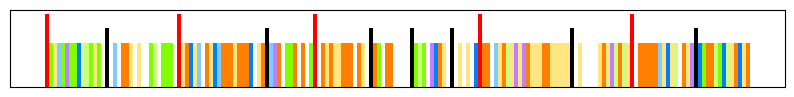

In [258]:
pred_flat = np.argmax(logits, axis=1).flatten()
print(list(pred_flat))
print(list(results))

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

data = results
def recolor(i):
    if i == -1:
        return [0, 0, 0]
    
    if i == 0:  # dekker, orange
        return [1, 0.5, 0]
    elif i == 0 + 9:  # dekker, orange
        return [1, 0.9, 0.5]
    elif i == 6: # rowley, green
        return [0.5, 1, 0]
    elif i == 6 + 9: # rowley, green
        return [0.8, 1, 0.5]
    elif i == 2: # ford, blue
        return [0, 0.5, 1]
    elif i == 2 + 9: # ford, blue
        return [0.5, 0.8, 1]
    elif i == 8: # webster, purple
        return [0.5, 0, 1]
    elif i == 8 + 9: # webster, purple
        return [0.75, 0.5, 1]
    
    # if i == 7:  # shakespeare, yellow
    #     return [1, 1, 0]
    # elif i == 7 + 9:  # shakespeare, yellow
    #     return [1, 1, 0.5]
    # elif i == 1: # fletcher, blue
    #     return [0.2, 0.3, 0.8]
    # elif i == 1 + 9: # fletcher, blue
    #     return [0.6, 0.7, 0.9]

    # if i == 7:  # shakespeare, yellow
    #     return [1, 1, 0]
    # # elif i == 7 + 9:  # shakespeare, yellow
    # #     return [1, 1, 0.5]
    # elif i == 5: # middleton, blue
    #     return [0, 1, 1]
    # # elif i == 5 + 9: # middleton, blue
    # #     return [0.5, 1, 1]

    return [1, 1, 1]

print(delimiter_idx)
colors = [recolor(-1 if i in delimiter_scene_idx else data[i]) for i in range(len(data))]
colors = [([1, 0, 0] if i in delimiter_idx else colors[i] )for i in range(len(data))]
heights = [(0.8 if i in delimiter_scene_idx else 0.6) for i in range(len(data))]
heights = [(1.0 if i in delimiter_idx else heights[i]) for i in range(len(data))]
positions = np.arange(len(data))
fig, ax = plt.subplots(figsize=(10, 1))
ax.bar(positions, heights, color=colors, width=1.0, edgecolor="none")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [195]:
# PLOT CLASSIFICATION LOGITS

import torch.nn.functional as F
import matplotlib.pyplot as plt

x = np.array(authors)
y = np.array(F.softmax(logits).detach().numpy()[0])

plt.figure(figsize=(16, 3))
plt.bar(x,y)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [263]:
a = outputs.attentions

In [266]:
a[0].shape

torch.Size([16, 12, 128, 128])